In [1]:
from scipy.special import j1, jnp_zeros, jvp
import numpy as np
from mpmath import nsum, inf, besselj, besseljzero, exp
from matplotlib import pyplot as plt

# Implementing the randomly oriented cylinder diffusion model following Palombo et al, 2017, MRM

After validating the Linse et al formula implementation, here I try and reproduce Palombos signal decays. Which works now :)

In [30]:
t_Delta  = 63.2 # ms
D = .332 # µm² / ms
r = .024 # µm

qs = np.arange(1e-9,1.5,2e-2) # spatial frequency of diffusion gradient

#t_delta = 100000 # ms
#gamma_gs = 2*np.pi*qs/t_delta # 1/(µm ms) frequency gradient

In [71]:

def q(b):
    return np.sqrt(b / (t_Delta - t_delta/3))


def b_nm(n, m, bessel_arg, D, r):
    # inner summand in general
    alpha_nm2 = jnp_zeros(n, m)[-1] ** 2
    return alpha_nm2 / (alpha_nm2 - n ** 2) / (alpha_nm2 - bessel_arg ** 2) ** 2 * np.exp(-D * alpha_nm2 * t_Delta / r ** 2)

    
def E_theta(q, D, r, theta):
    # q value projections
    q_perp = q*np.sin(theta)
    q_para = q*np.cos(theta)
    # helpers
    bessel_arg = q_perp*r


    # calculate inner sum
    def a_n(n):
        
        #define summand dependent on n
        def this_b_m(m):
            return b_nm(n, m, bessel_arg, D, r)
            
        B = nsum(this_b_m, [1,inf])
        
        #outer summand
        return jvp(int(n), bessel_arg) ** 2 * B / (1 + (int(n) == 0))
        
    # caculate outer sum
    return ((2 * j1(bessel_arg)) ** 2 / bessel_arg ** 2 + 8 * bessel_arg ** 2 * nsum(a_n, [0, inf])) * np.exp(-D * q_para ** 2 * t_Delta)

def E(q, D, r, n_theta=1e2):
    delta_theta = np.pi/n_theta
    thetas = np.arange(1e-15,np.pi,delta_theta)
    return np.sin(thetas)*delta_theta*np.sum([E_theta(q, D, r, theta) for theta in thetas])/2


In [72]:
qs = np.array([.05,1]) # spatial frequency of diffusion gradient

In [73]:
E_v_q = np.array([E(q,D,r,n_theta=5e1) for q in qs])



In [70]:
E_v_q

array([mpf('0.982474002080855'), mpf('0.19344446632060386')], dtype=object)

In [60]:
E_v_q

array([mpf('0.98270814599399903'), mpf('0.19344446632079232')],
      dtype=object)

## Find derivatives

In [ ]:


def db_dD_nm(n, m, bessel_arg, D, r):
    # inner summand in general
    alpha_nm2 = jnp_zeros(n, m)[-1] ** 2
    return alpha_nm2**2 / (alpha_nm2 - n ** 2) / (alpha_nm2 - bessel_arg ** 2) ** 2 * np.exp(-D * alpha_nm2 * t_Delta / r ** 2)

def dE_dD_theta(q, D, r, theta):
    # q value projections
    q_perp = q * np.sin(theta)
    q_para = q * np.cos(theta)
    # helpers
    bessel_arg = q_perp * r

    # calculate inner sum
    def a_n(n):
        # define summand dependent on n
        def this_b_m(m):
            return b_nm(n, m, bessel_arg, D, t_Delta, r)

        B = nsum(this_b_m, [1, inf])

        # outer summand
        return jvp(int(n), bessel_arg) ** 2 * B / (1 + (int(n) == 0))

    def da_dD_n(n):
        # define summand dependent on n
        def this_db_dD_m(m):
            return db_dD_nm(n, m, bessel_arg, D, r)

        dB_dD = nsum(this_db_dD_m, [1, inf])

        # outer summand
        return jvp(int(n), bessel_arg) ** 2 * dB_dD / (1 + (int(n) == 0))

    dA_dD = - t_Delta / r**2 * nsum(da_dD_n, [0, inf] )
    # caculate outer sum
    return (-q_para ** 2 * t_Delta * E_theta(q, D, r, theta)
            + 8 * (q_perp * r) ** 2 * np.exp(-D * q_para ** 2 * t_Delta) * dA_dD)

    #return ((-q_para**2* t_Delta)*((2 * j1(bessel_arg)) ** 2 / bessel_arg ** 2 + 8 * bessel_arg ** 2 * nsum(a_n, [0, inf]))
    #        + 8*(q_perp*r)**2 * dA_dD) * np.exp( -D * q_para ** 2 * t_Delta)

def dE_dD(q, D, r, n_theta=1e2):
    delta_theta = np.pi/n_theta
    thetas = np.arange(1e-15,np.pi,delta_theta)
    return np.sum([np.sin(theta)*dE_dD_theta(q, D, r, theta)*delta_theta for theta in thetas])/2



In [177]:
dE_dD_v_q = np.array([dE_dD(q,t_Delta,r,n_theta=1e2) for q in qs])

In [178]:
dE_dD_v_q

array([mpf('-0.0022183792250401505'), mpf('-0.00055468741783352776'),
       mpf('-0.0002214832295806934'), mpf('-0.00010080875933847463'),
       mpf('-3.8042241195622115e-5')], dtype=object)

In [6]:
E_v_q = np.array([E(q,D,r,n_theta=1e2) for q in qs])

ZeroDivisionError: 

In [170]:
E_v_q_dD = np.array([E(q,D+1e-12,r,n_theta=1e2) for q in qs])

In [172]:
(E_v_q_dD-E_v_q)/1e-12

array([mpf('-0.050737192225369654'), mpf('-0.52180482157382357'),
       mpf('-0.57420734833613096'), mpf('-0.36412539650143572'),
       mpf('-0.29129476608602545')], dtype=object)

In [169]:
(E_v_q_dD-E_v_q)/1e-9

array([mpf('-0.051026849412494357'), mpf('-0.52189763621868224'),
       mpf('-0.57408777731637883'), mpf('-0.364184155055014'),
       mpf('-0.29133406798109718')], dtype=object)

Use mpmath functions to speed up calculation maybe?

In [118]:
jnp_zeros(1,1)[-1]

1.8411837813406595

In [122]:
besseljzero(1,1,derivative=1)

mpf('1.8411837813406593')

In [124]:
jvp(1,1)

0.32514710081303305

In [126]:
besselj(1,1,derivative=1)

mpf('0.32514710081303305')

In [128]:
j1(1)

0.44005058574493355

In [129]:
besselj(1,1)

mpf('0.44005058574493352')

In [4]:
def q(gamma_g, t_delta):
    return gamma_g * t_delta

def b_nm(n,m,bessel_arg,D,t_Delta,r):
    # inner summand in general
    alpha_nm2 = besseljzero(n,m,derivative=1)**2
    return alpha_nm2 / (alpha_nm2 - n**2) / (alpha_nm2-bessel_arg**2)**2 * exp(-D*alpha_nm2*t_Delta/r**2)


def E_theta(q, t_Delta, r, theta):
    # q value projections
    q_perp = q*np.sin(theta)
    q_para = q*np.cos(theta)
    # helpers
    bessel_arg = q_perp*r


    # calculate inner sum
    def a_n(n):

        #define summand dependent on n
        def this_b_m(m):
            return b_nm(n,m,bessel_arg,D,t_Delta,r)

        B = nsum(this_b_m, [1,inf])

        #outer summand
        return besselj(int(n), bessel_arg,derivative=1)**2 * B / (1+(int(n)==0))

    #caculate outer sum
    return ( (2 * besselj(1,bessel_arg))**2 / bessel_arg**2  +  8*bessel_arg**2 * nsum(a_n,[0,inf]) ) * exp(-D * q_para**2 * t_Delta)

def E(q, t_Delta, r, n_theta=1e2):
    delta_theta = np.pi/n_theta
    thetas = np.arange(1e-15,np.pi,delta_theta)
    return np.sum([np.sin(theta)*E_theta(q, t_Delta, r, theta)*delta_theta for theta in thetas])/2 #



Try to vectorize

In [138]:
def b_nm(n,m,bessel_arg,D,t_Delta,r):
    # inner summand in general
    alpha_nm2 = jnp_zeros(n,m)[-1]**2
    return alpha_nm2 / (alpha_nm2 - n**2) / (alpha_nm2-bessel_arg**2)**2 * np.exp(-D*alpha_nm2*t_Delta/r**2)


def E(q, t_Delta, r, n_theta=1e2):
    delta_theta = np.pi/n_theta
    thetas = np.arange(1e-15,np.pi,delta_theta)

    # q value projections
    q_perps = q*np.sin(thetas)
    q_paras = q*np.cos(thetas)
    # helpers
    bessel_args = q_perps*r

    # calculate inner sum
    def a_n(n):
        #define summand dependent on n
        def this_b_m(m):
            return b_nm(n,m,bessel_args,D,t_Delta,r)

        B = nsum(this_b_m, [1,inf])

        #outer summand
        return jvp(int(n), bessel_args)**2 * B / (1+(int(n)==0))

    #caculate outer sum
    E_thetas = ( (2 * j1(bessel_args))**2 / bessel_args**2  +  8*bessel_args**2 * nsum(a_n,[0,inf]) ) * np.exp(-D * q_paras**2 * t_Delta)

    return E_thetas
    #np.sum([np.sin(theta)*E_theta(q, t_Delta, r, theta)*delta_theta for theta in thetas])/2 #



Everything ok ;) The lineshape is good, but my result appeared much larger than Palombis, ie a factor 10!
However, this was only due to a different logscale: They use basis e, why on earth, but well ok.

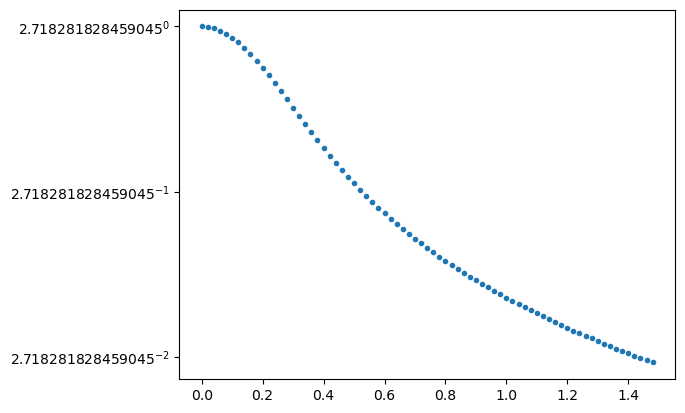

In [104]:
plt.semilogy(qs, E_v_q,'.',base = np.e)
#plt.ylim([0.01,1])

## Evaluate E_theta at 90° following Linse et al. 1995

Validate formula by reproducing Fig. 3 in Linse et al!

In [114]:

def b_nm(n,m,bessel_arg,D,t_Delta,r): 
    # inner summand in general
    alpha_nm2 = jnp_zeros(n,m)[-1]**2
    return alpha_nm2 / (alpha_nm2 - n**2) / (alpha_nm2-bessel_arg**2)**2 * np.exp(-D*alpha_nm2*t_Delta/r**2)

    
def E_theta(q, t_Delta, theta, r):
    # q value projections
    q_perp = q*np.sin(theta)
    q_para = q*np.cos(theta)
    # helpers
    bessel_arg = q_perp*r


    # calculate inner sum
    def a_n(n):
        
        #define summand dependent on n
        def this_b_m(m):
            return b_nm(n,m,bessel_arg,D,t_Delta,r)
            
        B = nsum(this_b_m, [1,inf])
        
        #outer summand
        return jvp(int(n), bessel_arg)**2 * B / (1+(int(n)==0))
        
    #caculate outer sum
    A = nsum(a_n,[0,inf])
    
    return ((2*j1(bessel_arg))**2/bessel_arg**2 + 8*bessel_arg**2 * A)* np.exp(-D*q_para**2*t_Delta)


In [174]:
theta = np.pi/2

D=1
r=1

q_stars = np.arange(1e-9, 3.5,.01)
qs = q_stars * np.pi # Linse reduced units lead to this scaling
t_Delta_stars = np.array([.05,.1,.2,.5,1])
t_Deltas = t_Delta_stars * 4 # Linse reduced unit lead to this scaling
E_v_qs = np.array([[E_theta(q,t_Delta,theta,r) for q in qs] for t_Delta in t_Deltas])

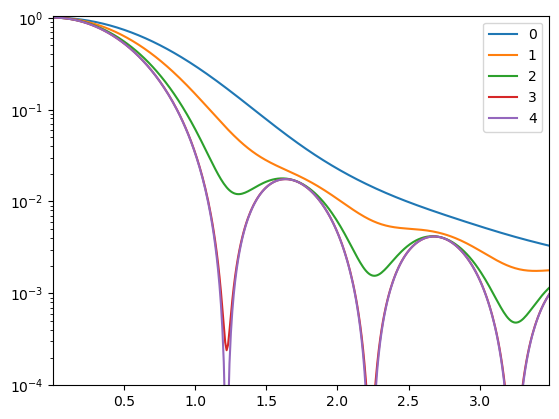

In [175]:
[plt.semilogy(q_stars, E_v_q,label=i) for i,E_v_q in enumerate(E_v_qs)]
plt.ylim(0.0001,1.05)
plt.xlim(q_stars[0],q_stars[-1])
plt.legend()

Beautiful! This is Linse and Södermann Fig 3b